In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from data_processing import *

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

print(X.shape)
X.head()


(1460, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [38]:
most_missing = get_missing_values_info(data)
most_missing

,Total,%
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945


In [39]:
data=data.drop(columns=['PoolQC', 'MiscFeature','Alley', 'Fence'], axis=1)

In [40]:
#magical seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=98987)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

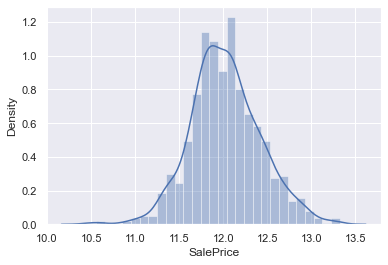

In [41]:
sns.distplot(y_train)

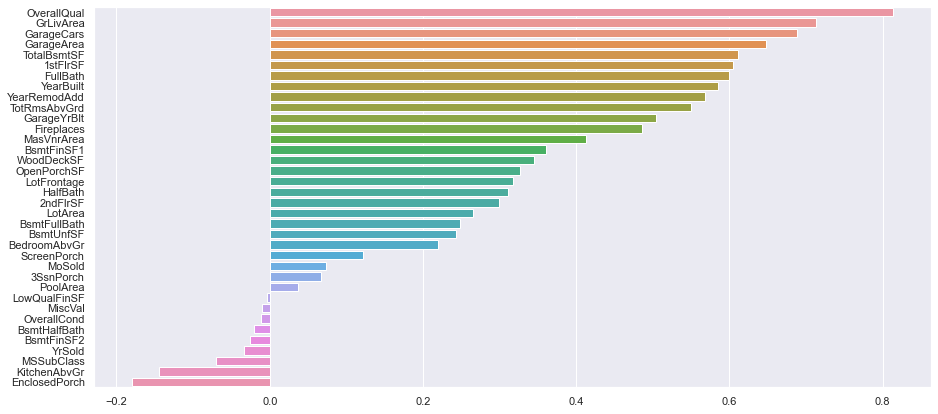

In [44]:
numeric_data = X_train.select_dtypes([np.number])

X_train_filled, data_mean = fill_nan(X_train)
X_test_filled = X_test.fillna(data_mean)

numeric_data_mean = numeric_data.mean()

numeric_features = numeric_data.columns

X_train_filled = X_train.fillna(numeric_data_mean)
X_test_filled = X_test.fillna(numeric_data_mean)

correlations = X_train_filled[numeric_features].corrwith(y_train).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 7)

<h2>Train on numeric data only</h2>

In [45]:
dtrain_matrix = xgb.DMatrix(numeric_data, label=y_train)

In [50]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dtrain_matrix, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.384388,0.003443,10.384393,0.008030
1,9.350517,0.003103,9.350523,0.008371
2,8.420056,0.002797,8.420062,0.008677
3,7.582699,0.002524,7.582704,0.008953
4,6.829170,0.002281,6.829174,0.009201


In [64]:
enc = one_hot_encode(X_train_filled)

In [65]:
enc.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
597,120,53.000000,3922,7,5,2006,2007,72.0,0,0,...,0,1,0,0,0,0,0,0,0,1
239,50,52.000000,8741,6,4,1945,1950,0.0,94,0,...,0,0,0,1,0,0,0,0,1,0
212,60,72.000000,8640,7,5,2009,2009,0.0,822,0,...,0,1,0,0,0,0,0,0,0,1
1155,20,90.000000,10768,5,8,1976,2004,0.0,1157,0,...,0,0,0,1,0,0,0,0,1,0
384,60,70.841121,53107,6,5,1992,1992,0.0,985,0,...,0,0,0,1,0,0,0,0,1,0


In [73]:
dtrain_matrix_enc = xgb.DMatrix(enc, label=y_train)

params = {"objective":"reg:squarederror", 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dtrain_matrix_enc, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10, metrics="rmsle", as_pandas=True, seed=123)

cv_results.head()

,train-rmsle-mean,train-rmsle-std,test-rmsle-mean,test-rmsle-std
0,1.592440,0.000151,1.592441,0.000732
1,1.262831,0.000098,1.262831,0.000784
2,1.037524,0.000070,1.037524,0.000811
3,0.870704,0.000054,0.870704,0.000827
4,0.741198,0.000043,0.741198,0.000838


In [63]:
xgbr = xgb.XGBRegressor( colsample_bytree=1.,
                 eta=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=14400,                                                                  
                 alpha=0.,
                 reg_lambda=0.4,
                 subsample=0.2)
scores = cross_val_score(xgbr, enc, y_train, cv=5, scoring='neg_root_mean_squared_error')
scores

array([-0.13820634, -0.1048266 , -0.11450468, -0.1473298 , -0.12067703])

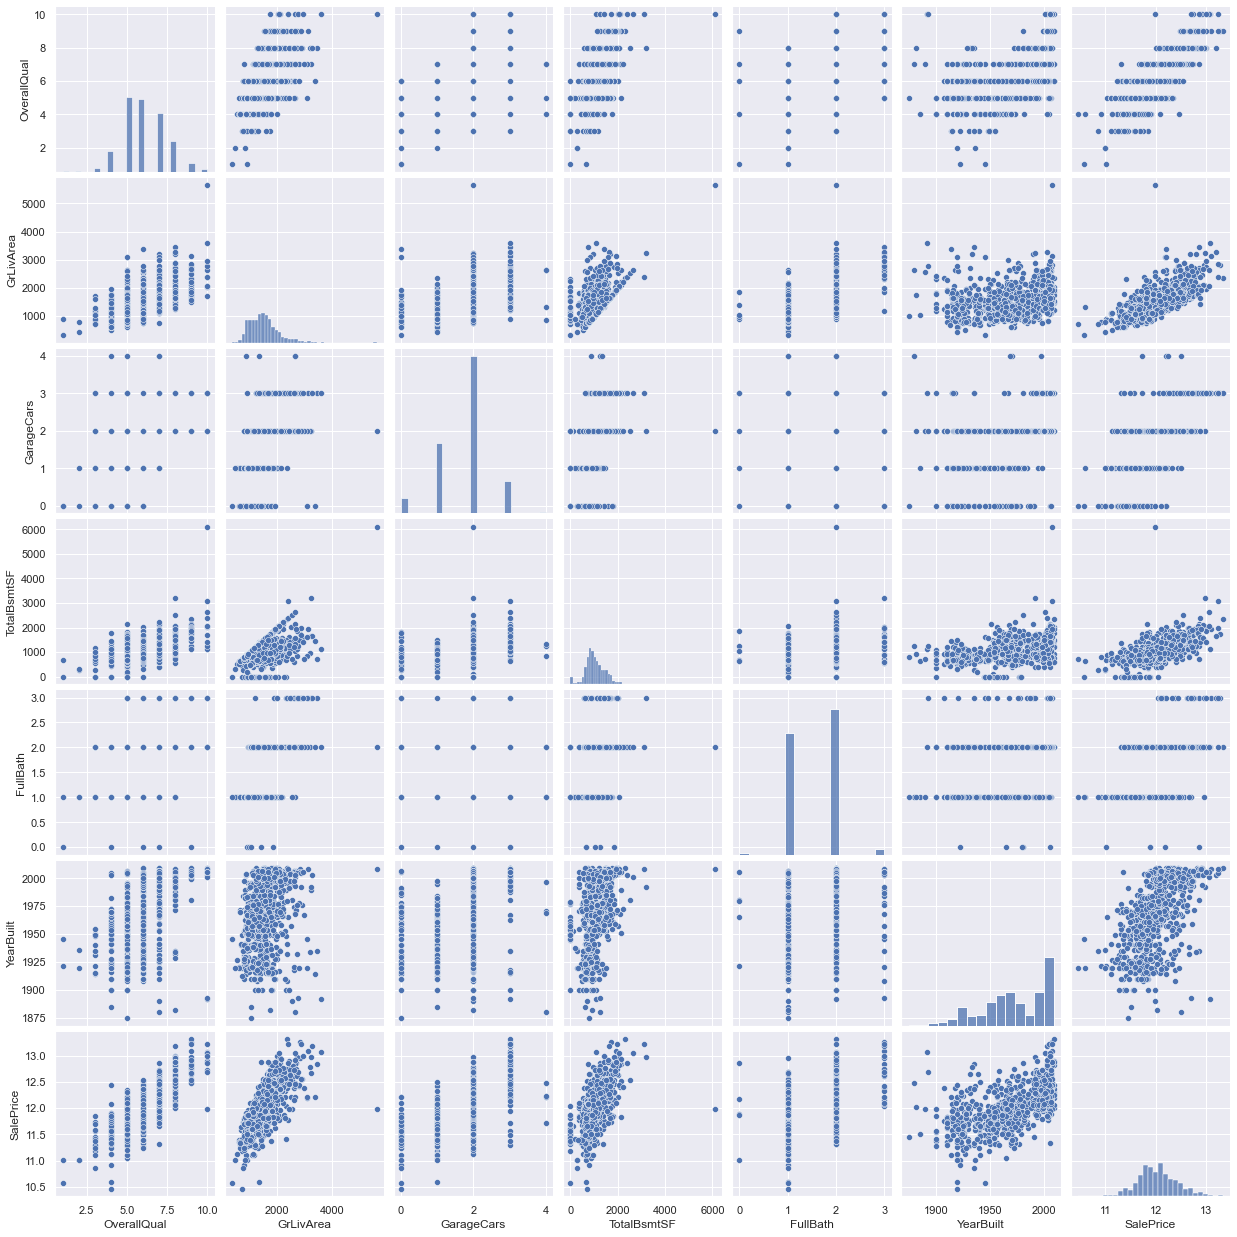

In [74]:
sns.set()
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(pd.concat([X_train_filled[cols], y_train], axis=1), size = 2.5)
plt.show()

In [129]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(enc)

ValueError: could not convert string to float: 'RL'

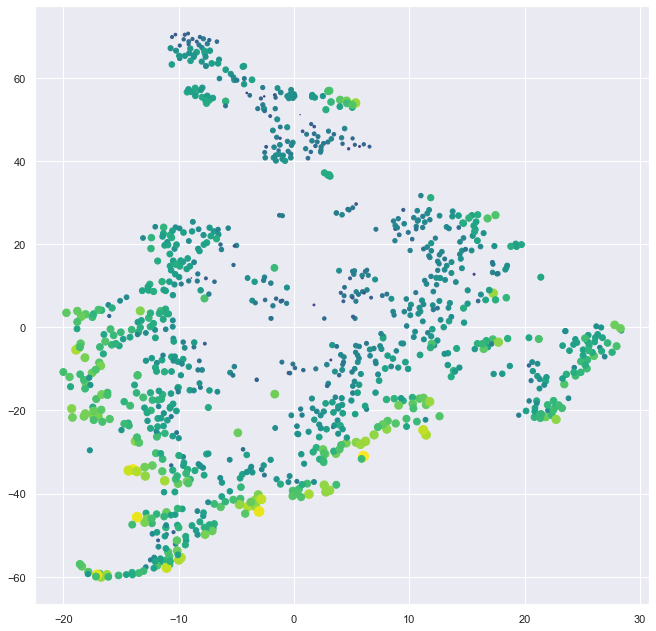

In [128]:
norm = plt.Normalize()

colors = plt.cm.viridis(norm(y_train))

min_y = y_train.min()
max_y = y_train.max()

plot = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s = np.float64(10*(y_train - min_y)/(max_y - min_y)) ** 2, c = colors)
plot.figure.set_size_inches(11, 11)